# Ispezione preliminare dei dati
Il codice che segue è relativo all'ispezione preliminare delle variabili contenute nel dataset associato all'articolo di Nathan Nunn, The Long-term Effects of Africa’s Slave Trades (The Quarterly Journal of Economics, 123(1):139–176, 2008).

**Per rappresentare i dati su mappe il codice che segue richiede la libreria geopandas**

# Importazione delle librerie

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento del dataset

In [2]:
fname = 'slave_trade_QJE.dta' # da https://nathannunn.sites.olt.ubc.ca/files/2022/02/DATA-22The-Long-Term-Effects-of-Africas-Slave-Trades22-slave_trade_qje_replication_dataset.zip

print('DATASET DESCRIPTION')
print('______________________________________________________________________')
with pd.io.stata.StataReader(fname) as reader:
    descr = reader.variable_labels()
    c = 0
    for item in descr.keys():
        print(str(c) + ')\t' + item + ': ' + descr[item])
        c=c+1

df = pd.read_stata(fname)

DATASET DESCRIPTION
______________________________________________________________________
0)	isocode: Country isocode
1)	country: Country name
2)	ln_maddison_pcgdp2000: Log per capita GDP - from Maddison (2003)
3)	ln_export_area: Log total slave exports normalized by land area
4)	ln_export_pop: Log total slave exports normalized by historic population
5)	colony0: Colonizer indicator: not colonized
6)	colony1: Colonizer indicator: Britan
7)	colony2: Colonizer indicator: France
8)	colony3: Colonizer indicator: Portugal
9)	colony4: Colonizer indicator: Belgium
10)	colony5: Colonizer indicator: Spain
11)	colony6: Colonizer indicator: UN
12)	colony7: Colonizer indicator: Italy
13)	abs_latitude: Absolute latitude
14)	longitude: Longitude
15)	rain_min: Min of monthly average rainfall (mm)
16)	humid_max: Max of monthly afternoon avg humidity (%)
17)	low_temp: Min of avg monthly low temp (C)
18)	ln_coastline_area: Log (coastline/land_area)
19)	island_dum: Indicator variable for small islands
2

# Visualizzazione dei dati su mappa
## Caricamento della mappa dell'Africa e merge con il dataset
Rispetto ai dati nell'articolo di Nunn gli Stati africani sono cambiati (ad esempio è nata la nazione del Sudan del Sud): in tutte le mappe (shapefile da https://www.naturalearthdata.com/) di questo report si è cercato di fondere, laddove necessario, gli attuali Paesi in modo da replicare la conformazione geopolitica corrispondente a quella del paper.

Riportiamo per comodità nella tabella seguente per ogni Paese il codice associato sulle varie mappe.
| isocode | Paese                    | isocode | Paese             | isocode | Paese        | isocode | Paese                |
|---      |---                       |---      |---                |---      |---           |---      |---                   |
| AGO     | Angola                   | EGY     | Egypt             | MDG     | Madagascar   | SOM     | Somalia              |
| BDI     | Burundi                  | ETH     | Ethiopia          | MLI     | Mali         | STP     | Sao Tome \& Principe |
| BEN     | Benin                    | GAB     | Gabon             | MOZ     | Mozambique   | SWZ     | Swaziland            |
| BFA     | Burkina Faso             | GHA     | Ghana             | MRT     | Mauritania   | SYC     | Seychelles           |
| BWA     | Botswana                 | GIN     | Guinea            | MUS     | Mauritius    | TCD     | Chad                 |
| CAF     | Central African Republic | GMB     | Gambia            | MWI     | Malawi       | TGO     | Togo                 |
| CIV     | Ivory Coast              | GNB     | Guinea-Bissau     | NAM     | Namibia      | TUN     | Tunisia              |
| CMR     | Cameroon                 | GNQ     | Equatorial Guinea | NER     | Niger        | TZA     | Tanzania             |
| COG     | Congo                    | KEN     | Kenya             | NGA     | Nigeria      | UGA     | Uganda               |
| COM     | Comoros                  | LBR     | Liberia           | RWA     | Rwanda       | ZAF     | South Africa         |
| CPV     | Cape Verde Islands       | LBY     | Libya             | SDN     | Sudan        | ZAR     | Dem. Rep. of Congo   |
| DJI     | Djibouti                 | LSO     | Lesotho           | SEN     | Senegal      | ZMB     | Zambia               |
| DZA     | Algeria                  | MAR     | Morocco           | SLE     | Sierra Leone | ZWE     | Zimbabwe             |


In [3]:
world = gpd.read_file("./AfricaShapefile/ne_10m_admin_0_countries.shp")
africa = world[world['REGION_UN'] == 'Africa']
africa.loc[ 14,'ISO_A3'] = 'SDN' # South Sudan -> Sudan
africa.loc[ 20,'ISO_A3'] = 'SOM' # Somaliland -> Somalia
africa.loc[ 27,'ISO_A3'] = 'MAR' # Western Sahara -> Morocco
africa.loc[ 31,'ISO_A3'] = 'ZAR' # Democratic Republic of Congo -> Zaire
africa.loc[ 87,'ISO_A3'] = 'ETH' # Eritrea -> Etiopia
africa.loc[174,'ISO_A3'] = '' # Bir Tawil -> Sudan/Egypt
#
africa = africa.drop(194, axis=0) # French Southern and Antarctic Lands -> France
africa = africa.drop(216, axis=0) # Heard Island and McDonald Islands -> Australia
africa = africa.drop(217, axis=0) # Saint Helena -> UK
africa = africa.drop(228, axis=0) # Indian Ocean Territories -> Australia
africa = africa.drop(229, axis=0) # British Indian Ocean Territory -> UK
#
africa_df = africa.merge(df, left_on='ISO_A3', right_on='isocode', how='left')
africa_df['colonizers'] = ['--'] * africa_df.shape[0]
for idx, row in africa_df.iterrows():
    if row.colony1 == 1:
        africa_df.loc[idx,'colonizers'] = 'GB'
    elif row.colony2 == 1:
        africa_df.loc[idx,'colonizers'] = 'FR'
    elif row.colony3 == 1:
        africa_df.loc[idx,'colonizers'] = 'PT'
    elif row.colony4 == 1:
        africa_df.loc[idx,'colonizers'] = 'BE'
    elif row.colony5 == 1:
        africa_df.loc[idx,'colonizers'] = 'ES'
    elif row.colony6 == 1:
        africa_df.loc[idx,'colonizers'] = 'UN'
    elif row.colony7 == 1:
        africa_df.loc[idx,'colonizers'] = 'IT'

africa_df['legor'] = ['--'] * africa_df.shape[0]
for idx, row in africa_df.iterrows():
    if row['legor_uk'] == 1:
        africa_df.loc[idx,'legor'] = 'GB'
    elif row['legor_fr'] == 1:
        africa_df.loc[idx,'legor'] = 'FR'

## Risposta $y$ e trattamento $d$

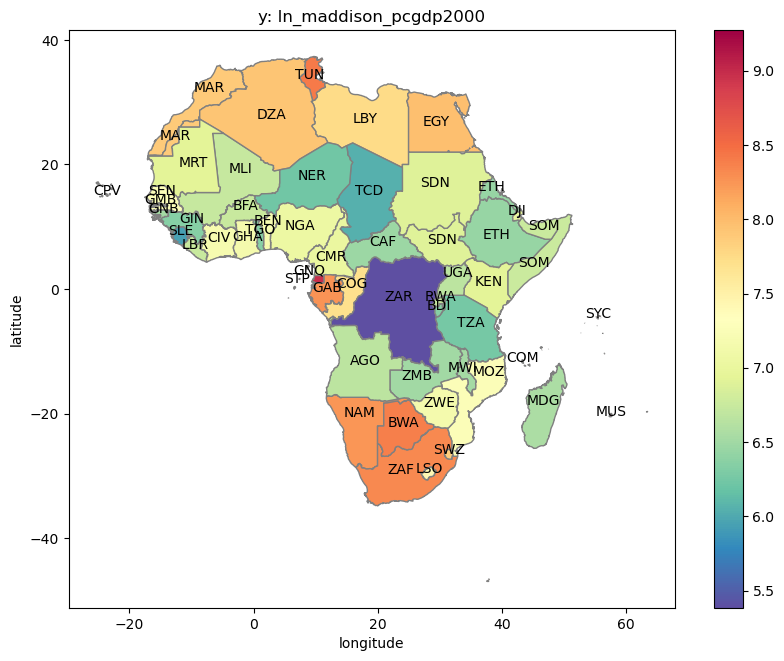

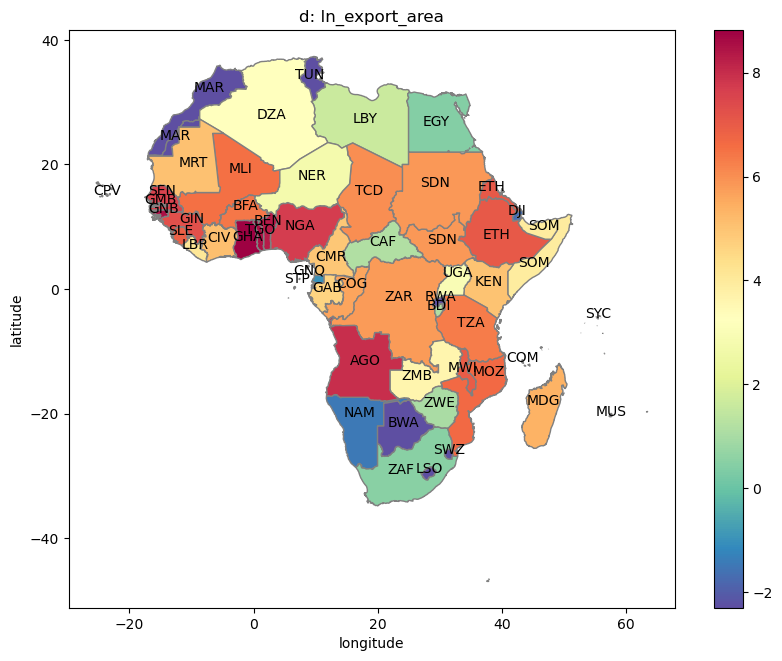

In [4]:
fig, ax = plt.subplots(figsize=(10, 7.5))
plot = africa_df.plot(ax=ax, edgecolor='gray', column='ln_maddison_pcgdp2000', 
               cmap='Spectral_r', legend=True,)
for idx, row in africa_df.iterrows():
    ax.annotate(text=row.ISO_A3, xy=(row.LABEL_X,row.LABEL_Y), horizontalalignment='center')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_title('y: ln_maddison_pcgdp2000')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7.5))
plot = africa_df.plot(ax=ax, edgecolor='gray', column='ln_export_area', 
               cmap='Spectral_r', legend=True,)
for idx, row in africa_df.iterrows():
    ax.annotate(text=row.ISO_A3, xy=(row.LABEL_X,row.LABEL_Y), horizontalalignment='center')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_title('d: ln_export_area')
plt.show()

Spicca il PIL pro capite molto basso della Repubblica Democratica del Congo (ex Zaire), probabilmente per la cleptocrazia del dittatore Mobutu fino alla fine degli anni '90 (i dati del PIL risalgono al 2000).

## Varibili geo-climatiche
Omettiamo le mappe che riportano la latitudine e longitudine dei centroidi dei vari Paesi.

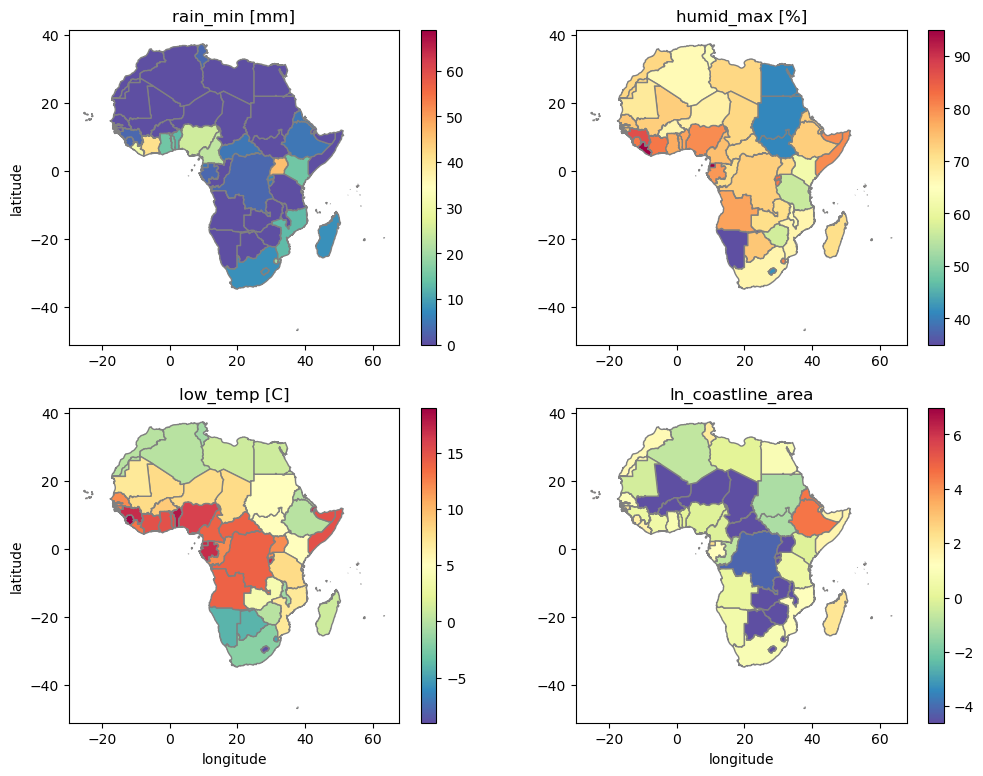

In [5]:
fig, axs = plt.subplots(2,2, figsize=(12, 9))
plot = africa_df.plot(ax=axs[0,0], edgecolor='gray', column='rain_min',
                      cmap='Spectral_r', legend=True)
axs[0,0].set_title('rain_min [mm]')
axs[0,0].set_ylabel('latitude');
#
plot = africa_df.plot(ax=axs[0,1], edgecolor='gray', column='humid_max',
                      cmap='Spectral_r', legend=True)
axs[0,1].set_title('humid_max [%]')
#
plot = africa_df.plot(ax=axs[1,0], edgecolor='gray', column='low_temp',
                      cmap='Spectral_r', legend=True)
axs[1,0].set_title('low_temp [C]')
axs[1,0].set_xlabel('longitude'); axs[1,0].set_ylabel('latitude');
#
plot = africa_df.plot(ax=axs[1,1], edgecolor='gray', column='ln_coastline_area',
                      cmap='Spectral_r', legend=True)
axs[1,1].set_title('ln_coastline_area')
axs[1,1].set_xlabel('longitude'); 
plt.show()

## Passato coloniale
Le variabili colony0 ... colony7 riportano l'ultima dominazione coloniale prima dell'indipendenza.

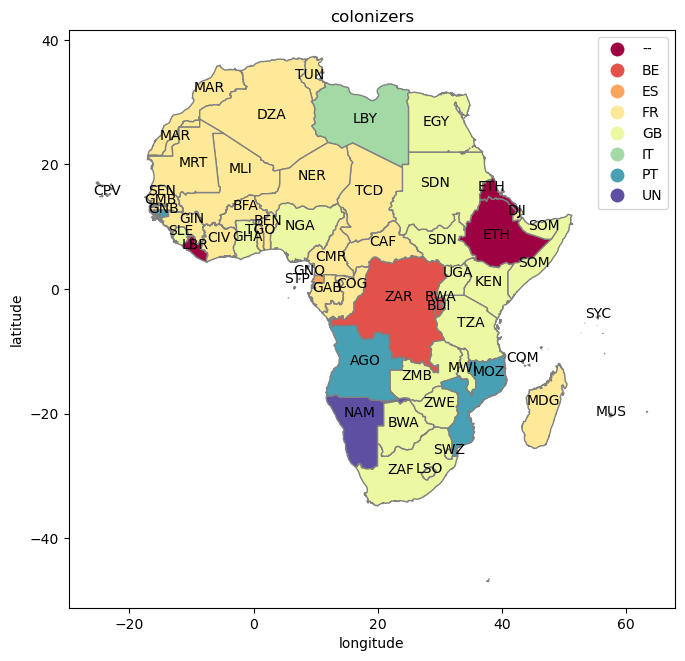

In [6]:
fig, ax = plt.subplots(figsize=(10, 7.5))
plot = africa_df.plot(ax=ax, edgecolor='gray', column='colonizers',
                      cmap='Spectral', legend=True, categorical=True,)
for idx, row in africa_df.iterrows():
    plt.annotate(text=row.ISO_A3, xy=(row.LABEL_X,row.LABEL_Y), horizontalalignment='center')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_title('colonizers')
plt.show()

## Fede islamica

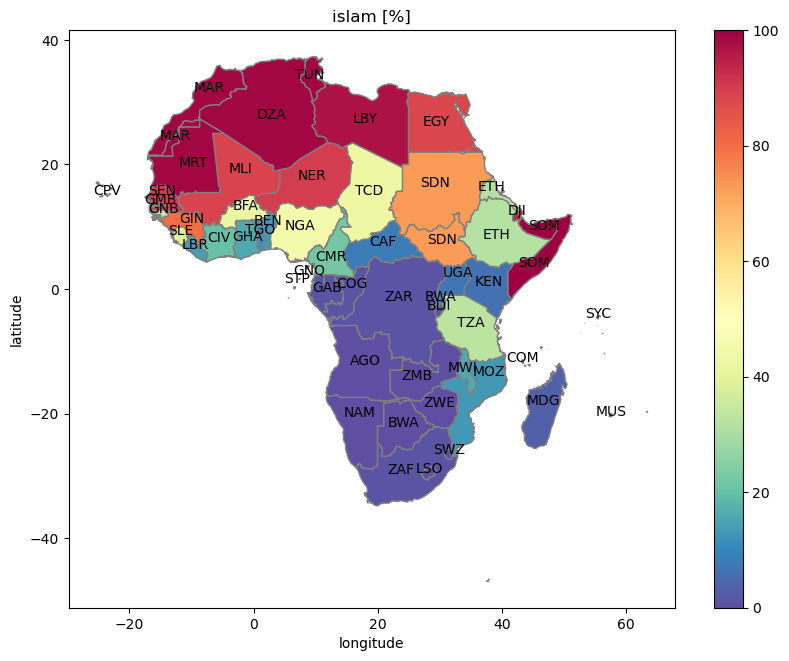

In [7]:
fig, ax = plt.subplots(figsize=(10, 7.5))
plot = africa_df.plot(ax=ax, edgecolor='gray', column='islam',
                      cmap='Spectral_r', legend=True)
for idx, row in africa_df.iterrows():
    plt.annotate(text=row.ISO_A3, xy=(row.LABEL_X,row.LABEL_Y), horizontalalignment='center')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_title('islam [%]')
plt.show()

## Base legislativa

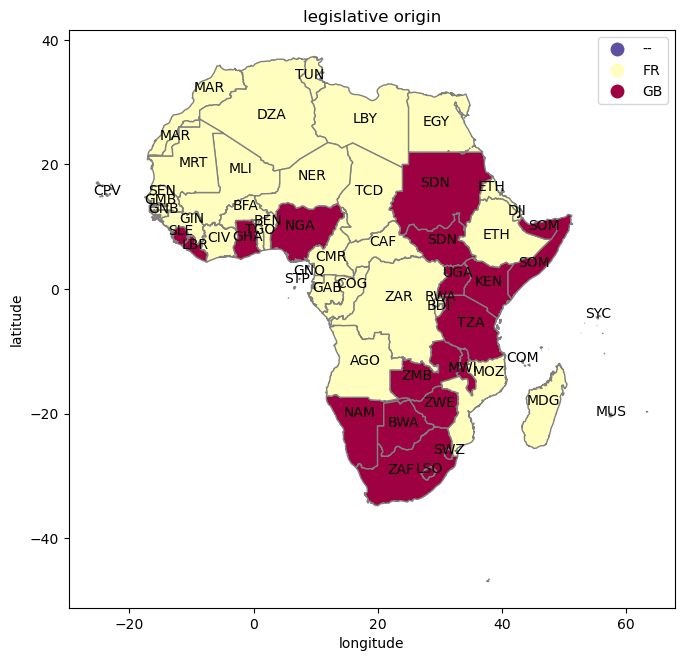

In [8]:
fig, ax = plt.subplots(figsize=(10, 7.5))
plot = africa_df.plot(ax=ax, edgecolor='gray', column='legor',
                      cmap='Spectral_r', legend=True, categorical=True,)
for idx, row in africa_df.iterrows():
    plt.annotate(text=row.ISO_A3, xy=(row.LABEL_X,row.LABEL_Y), horizontalalignment='center')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_title('legislative origin')
plt.show()

## Produzione minerarie

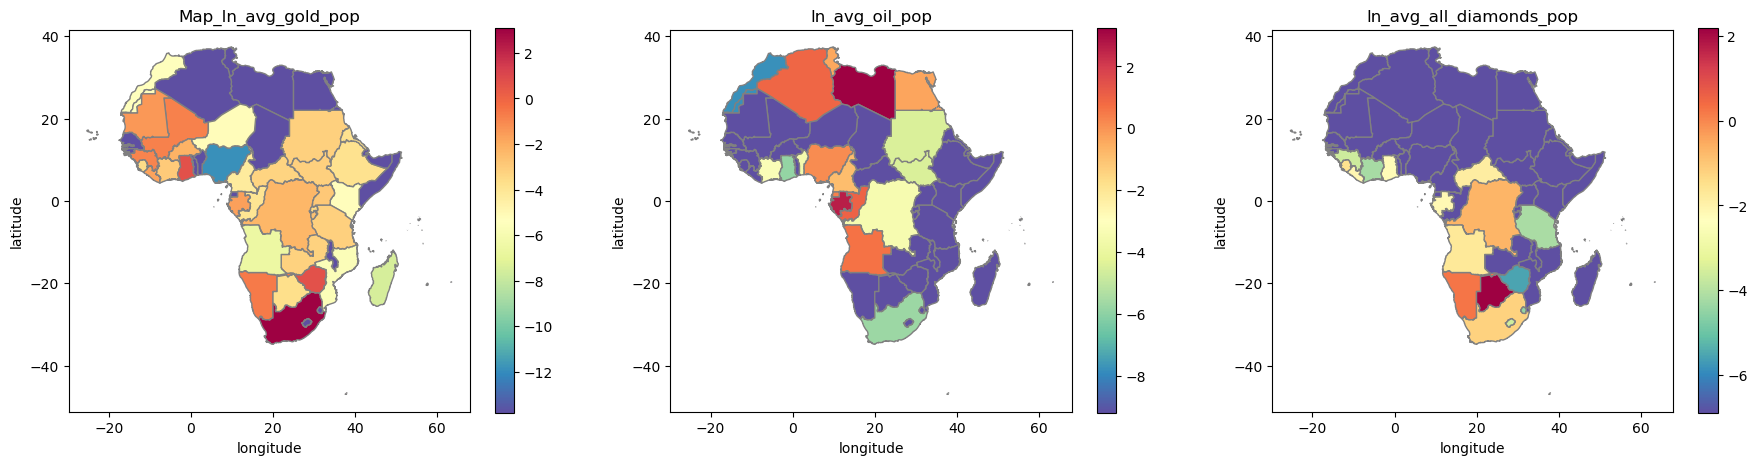

In [9]:
fig, axs = plt.subplots(1,3, figsize=(22, 5))
plot = africa_df.plot(ax=axs[0], edgecolor='gray', column='ln_avg_gold_pop',
                      cmap='Spectral_r', legend=True)
_ = axs[0].set_xlabel('longitude'); _ = axs[0].set_ylabel('latitude');
_ = axs[0].set_title('Map_ln_avg_gold_pop')
#
plot = africa_df.plot(ax=axs[1], edgecolor='gray', column='ln_avg_oil_pop',
                      cmap='Spectral_r', legend=True)
_ = axs[1].set_xlabel('longitude'); _ = axs[1].set_ylabel('latitude');
_ = axs[1].set_title('ln_avg_oil_pop')
#
plot = africa_df.plot(ax=axs[2], edgecolor='gray', column='ln_avg_all_diamonds_pop',
                      cmap='Spectral_r', legend=True)
_ = axs[2].set_xlabel('longitude'); _ = axs[2].set_ylabel('latitude');
_ = axs[2].set_title('ln_avg_all_diamonds_pop')
plt.show()

## Variabili strumentali
Le variabili strumentali proposte da Nunn sono le distanze tra ciascun Paese
africano e le località in cui gli schiavi venivano richiesti. Poiché la posizione
dell’offerta non è stata influenzata dalla localizzazione della domanda, tali IV
costituiscono degli strumenti validi. Nunn ha individuato quattro variabili strumentali, relative alle quattro tratte di schiavi subite dall'Africa:
- **Tratta transatlantica** La distanza di navigazione *atlantic_distance_minimum*
dal punto della costa africana più prossimo al centroide del Paese al più
vicino mercato principale in America.
- **Tratta sull’Oceano Indiano** La distanza di navigazione *indian_distance_minimum*
dal punto della costa a minima distanza dal centroide del Paese alla più
vicina delle due principali destinazioni, cioè Mauritius e Mascate (in Oman).
- **Tratta trans-sahariana** La distanza via terra dal
centroide di un Paese al porto di esportazione più vicino, cioè Algeri,
Tunisi, Tripoli, Bengasi e Il Cairo (*saharan_distance_minimum*).
- **Tratta del Mar Rosso** La distanza via terra *red_sea_distance_minimum* dal centroide di un Paese al porto di
esportazione più vicino tra Massaua, Suakin e Gibuti.

Per i Paesi insulari, non è possibile raggiungere i porti della tratta degli schiavi
del Sahara o del Mar Rosso viaggiando via terra: per questi Paesi Nunn ha
utilizzato la somma della distanza di navigazione e della distanza via terra.


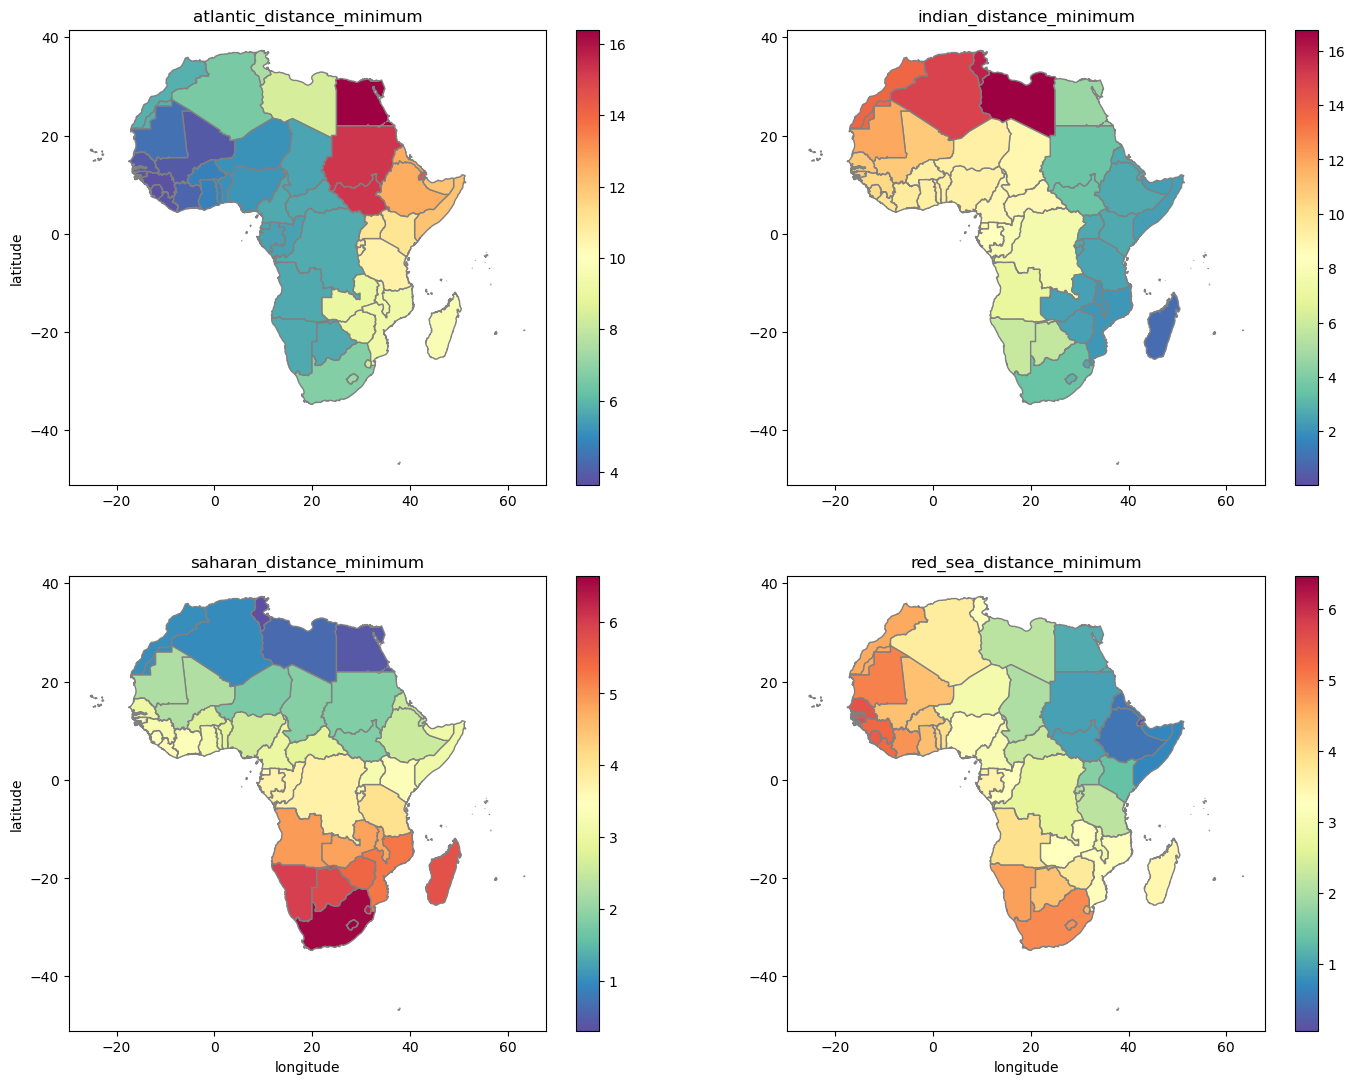

In [10]:
fig, axs = plt.subplots(2,2, figsize=(17, 13)) #
plot = africa_df.plot(ax=axs[0,0], edgecolor='gray', column='atlantic_distance_minimum',
                      cmap='Spectral_r', legend=True)
axs[0,0].set_title('atlantic_distance_minimum') 
axs[0,0].set_ylabel('latitude');
#
plot = africa_df.plot(ax=axs[0,1], edgecolor='gray', column='indian_distance_minimum',
                      cmap='Spectral_r', legend=True)
axs[0,1].set_title('indian_distance_minimum')
#
plot = africa_df.plot(ax=axs[1,0], edgecolor='gray', column='saharan_distance_minimum',
                      cmap='Spectral_r', legend=True)
axs[1,0].set_title('saharan_distance_minimum')
axs[1,0].set_xlabel('longitude'); axs[1,0].set_ylabel('latitude');
#
plot = africa_df.plot(ax=axs[1,1], edgecolor='gray', column='red_sea_distance_minimum',
                      cmap='Spectral_r', legend=True)
axs[1,1].set_title('red_sea_distance_minimum')
axs[1,1].set_xlabel('longitude');

plt.show()